In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *



/Applications/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Applications/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Prepare Train and Test Dataset

In [24]:
df = pd.read_csv("../labeled_dataAll.csv", index_col='ID')
df.head(5)

,Label_alpha,Label_num,Drug,Food,sentence
ID,,,,,
400,neutral,1,ACE inhibitor,pentadecanoic acid,(123)iodine labelled beta-methyl-iodophenyl pe...
333,positive,2,ACE inhibitor,2-phenylethanol,2-Phenylethanol is a widely used aroma compoun...
77,positive,2,ACE inhibitor,"3,4-dihydroxyphenylacetic acid","3,4-dihydroxyphenylacetic acid and 4-methylcat..."
338,neutral,1,ACE inhibitor,arachin,A 96-well microplate format of this method was...
214,neutral,1,ACE inhibitor,diethylamine,A biochemical study was performed in order to ...


In [25]:
drugs = df.Drug.unique()
print drugs
add_dict = {}

for drug in drugs:
    
    count_list = []
    for i in range(3):
        count = len(df[(df.Drug == drug) & (df.Label_num == i)])
        count_list.append(count)
        
    max_count = max(count_list)
    add_list = [max(0,max_count-c) for c in count_list]
    add_dict[drug] = add_list


['ACE inhibitor' 'Antacid' 'GLP-1' 'Thyroxine' 'Statin' 'Acetaminophen'
 'Digoxin' 'Isoniazid' 'Antihistamine' 'MOAI' 'Analgesics'
 'Bronchodialators']


In [26]:
print add_dict

{'GLP-1': [109, 0, 59], 'Thyroxine': [66, 0, 85], 'MOAI': [34, 2, 0], 'Antihistamine': [18, 0, 5], 'Analgesics': [8, 2, 0], 'Digoxin': [116, 0, 132], 'Isoniazid': [39, 0, 42], 'Acetaminophen': [334, 0, 435], 'Statin': [196, 0, 171], 'Antacid': [22, 0, 16], 'Bronchodialators': [12, 0, 2], 'ACE inhibitor': [272, 0, 107]}


In [27]:
print len(df)

2471


In [28]:
for drug in drugs:
    for i in range(3):
        temp = df[(df.Drug == drug) & (df.Label_num == i)].sample(add_dict[drug][i], replace=True)
        df = df.append(temp)

print len(df)

4755


In [31]:
print sum([j for i in add_dict.values() for j in i]) + 2471

4755


In [32]:
# Randomly shuffle the data. Use same random seed to get same results every time. 
df_shuffle = df.sample(frac=1, random_state=0).reset_index(drop=True)

# Separate labels
labels = [i for i in df_shuffle.Label_num]
labels = np.array(labels)
n = len(labels)

# Drop unecessary columns from input data
df_shuffle.drop('Label_alpha', axis=1, inplace=True)
df_shuffle.drop('Label_num', axis=1, inplace=True)
df_shuffle.drop('Drug', axis=1, inplace=True)
df_shuffle.drop('Food', axis=1, inplace=True)


# Split the train data into training and dev datasets
train_data =  df_shuffle[:n/2].sentence.tolist()
dev_data = df_shuffle[n/2: 3*n/4].sentence.tolist()
test_data = df_shuffle[3*n/4:].sentence.tolist()

# Separate training and dev labels
train_labels =  labels[:n/2]
dev_labels = labels[n/2: 3*n/4]
test_labels = labels[3*n/4:]

In [33]:
print 'training label shape:', train_labels.shape
print 'test label shape:', test_labels.shape
print 'dev label shape:', dev_labels.shape

training label shape: (2377,)
test label shape: (1189,)
dev label shape: (1189,)


In [34]:
classes = ['negative', 'neutral', 'positive'] # corresponding labels = 0, 1, 2
classes_dict = {0:'negative', 1:'neutral', 2:'positive'} # corresponding labels = 0, 1, 2

In [35]:
def count_classes(value, labels):
    return len([i for i in labels if i == value])

In [36]:
# Check number of classes per train/dev/test dataset:
print "Dataset split among Negative, Neutral and Positive"

print "{0:>15} |{1:>15} |{2:>15} |{3:>15}".format("dataset","negative", "neutral", "positive")
print "{0:>15} |{1:>15f} |{2:>15f} |{3:>15f}".format("train",count_classes(0,train_labels), 
                                                     count_classes(1,train_labels),
                                                     count_classes(2,train_labels))
print "{0:>15} |{1:>15f} |{2:>15f} |{3:>15f}".format("dev",count_classes(0,dev_labels), 
                                                     count_classes(1,dev_labels),
                                                     count_classes(2,dev_labels))
print "{0:>15} |{1:>15f} |{2:>15f} |{3:>15f}".format("test",count_classes(0,test_labels), 
                                                     count_classes(1,test_labels),
                                                     count_classes(2,test_labels))

Dataset split among Negative, Neutral and Positive
        dataset |       negative |        neutral |       positive
          train |     784.000000 |     797.000000 |     796.000000
            dev |     387.000000 |     400.000000 |     402.000000
           test |     414.000000 |     388.000000 |     387.000000


In [37]:
# Check few sentences

def print_examples(num_examples=5):

    for i in range(num_examples):
        print "Training example", i+1
        print "Label", train_labels[i], "(", classes_dict[train_labels[i]],")"
        print "Sentence:\n", train_data[i], "\n\n"
       
    
print_examples(5)

Training example 1
Label 0 ( negative )
Sentence:
Ultrasonic imaging revealed enlarged thyroid glands with lowered echotexture and relatively heterogeneous features in the high-fat lard fed rats. 


Training example 2
Label 1 ( neutral )
Sentence:
In order to develop a practicable, reliable and cost-effective bioassay suitable for routine testing, a combined dot-blot/RNAse protection assay, utilising digoxigenin-labelled cRNA transcripts of plasmid psg5Vg1.1 was used for the quantification of vitellogenin-mRNA in isolated rainbow trout (Oncorhynchus mykiss) hepatocytes.\ 


Training example 3
Label 0 ( negative )
Sentence:
Additionally, atorvastatin (10, 20 mg/kg), simvastatin (30 mg/kg) and fluvastatin (10 mg/kg) significantly decrease the TNF- level and striatal lesion volume in quinolinic acid treated animals indicating their anti-inflammatory effects. 


Training example 4
Label 1 ( neutral )
Sentence:
Three sets of drug-loaded crosslinked pectin wafers were produced employing the 

# Logistic Regression Model

In [38]:
# Turn the raw training text into feature vectors based on "td-idf"
vectorizer = TfidfVectorizer()
vocab_train_tf = vectorizer.fit_transform(train_data)
vocab_dev_tf = vectorizer.transform(dev_data)

In [40]:
import time
# Logistic Regression:
print "Evaluating Logistic Regression model ..."

# Create a Logistic Regression model. 
LRmodel = LogisticRegression(C=1.0)

# Create a grid search.
print "Performing grid search for Logistic Regression model. It may take a few minutes ..."
Cs = {'C': [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0]}
CV_LRmodel = GridSearchCV(estimator=LRmodel, param_grid=Cs)

# Fit the models using grid search and display the results.
start_time = time.time()
CV_LRmodel.fit(vocab_train_tf, train_labels)
end_time = time.time()
print "Logistic Regression grid search model fitting time = %f seconds." % (end_time - start_time)

optimal_Cs = CV_LRmodel.best_params_['C']
print "As per the grid search on the training data, the optimal value of C = %f." % optimal_Cs

# Construct model with optimal C
model_LR = LogisticRegression(C=optimal_Cs)
model_LR.fit(vocab_train_tf, train_labels)
    

Evaluating Logistic Regression model ...
Performing grid search for Logistic Regression model. It may take a few minutes ...
Logistic Regression grid search model fitting time = 0.802970 seconds.
As per the grid search on the training data, the optimal value of C = 50.000000.


LogisticRegression(C=50.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

# Dev Data

Dev dataset with 1189 sentences

Data split - Negative, Neutral, Positive
----------------------------------------
        dataset |       negative |        neutral |       positive
  dev_predicted |     399.000000 |     356.000000 |     434.000000
     dev_actual |     387.000000 |     400.000000 |     402.000000

Accuracy
--------
Accuracy (test data): 0.881

Classification Report
---------------------
             precision    recall  f1-score   support

          0       0.91      0.94      0.93       387
          1       0.88      0.79      0.83       400
          2       0.85      0.92      0.88       402

avg / total       0.88      0.88      0.88      1189


Confusion matrix for Dev data
-----------------------------
The most confused pair of classes is: 1 ( neutral )  incorrectly predicted as 2 ( positive )
Number of such confusion occurences: 58


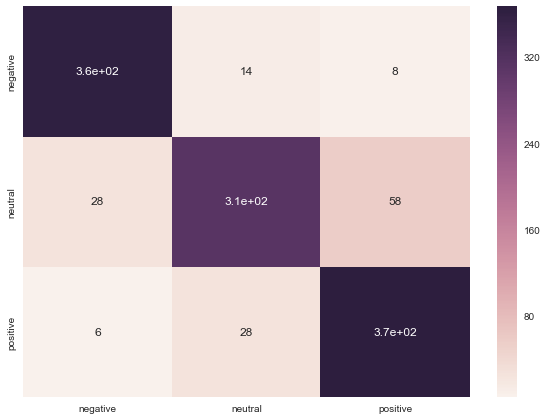

In [41]:
# Validation data
predicted_labels_LR = model_LR.predict(vocab_dev_tf)

print "Dev dataset with", len(predicted_labels_LR), "sentences"
print ""

print "Data split - Negative, Neutral, Positive"
print "----------------------------------------"
print "{0:>15} |{1:>15} |{2:>15} |{3:>15}".format("dataset","negative", "neutral", "positive")
print "{0:>15} |{1:>15f} |{2:>15f} |{3:>15f}".format("dev_predicted",count_classes(0,predicted_labels_LR), 
                                                     count_classes(1,predicted_labels_LR),
                                                     count_classes(2,predicted_labels_LR))
print "{0:>15} |{1:>15f} |{2:>15f} |{3:>15f}".format("dev_actual",count_classes(0,dev_labels), 
                                                     count_classes(1,dev_labels),
                                                     count_classes(2,dev_labels))


accuracy = model_LR.score(vocab_dev_tf, dev_labels)
print "\nAccuracy"
print "--------"
print "Accuracy (test data): %.3f" %(accuracy)

print "\nClassification Report"
print "---------------------"
print classification_report(dev_labels, predicted_labels_LR)

print "\nConfusion matrix for Dev data"
print "-----------------------------"

array = confusion_matrix(dev_labels, predicted_labels_LR)
df_cm = pd.DataFrame(array, index = ["negative", "neutral", "positive"],
                  columns = ["negative", "neutral", "positive"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

# Find the most confused pair
cm2 = confusion_matrix(dev_labels, predicted_labels_LR)  # copy the cm matrix so that can modify the copy without affecting original cm
np.fill_diagonal(cm2, 0)  # set the values in the diagonal = 0 to obtain number of confused pairs matrix
maximum_pair_idx = np.where(cm2 == cm2.max())  # returns the indices of the max value in cm matrix
true_interaction = maximum_pair_idx[0][0]
predicted_interaction = maximum_pair_idx[1][0]
max_wrong_prediction = cm2[true_interaction][predicted_interaction]
print "The most confused pair of classes is:", true_interaction, "(", classes_dict[true_interaction],")",\
" incorrectly predicted as", predicted_interaction, "(", classes_dict[predicted_interaction],")"
print "Number of such confusion occurences:", max_wrong_prediction

## Test data

Test dataset with 1189 sentences

Data split - Negative, Neutral, Positive
----------------------------------------
        dataset |       negative |        neutral |       positive
 test_predicted |     424.000000 |     336.000000 |     429.000000
    test_actual |     414.000000 |     388.000000 |     387.000000

Accuracy
--------
Accuracy (test data): 0.884

Classification Report
---------------------
             precision    recall  f1-score   support

          0       0.93      0.95      0.94       414
          1       0.90      0.78      0.83       388
          2       0.83      0.92      0.88       387

avg / total       0.89      0.88      0.88      1189


Confusion matrix for test data
------------------------------
The most confused pair of classes is: 1 ( neutral )  incorrectly predicted as 2 ( positive )
Number of such confusion occurences: 60


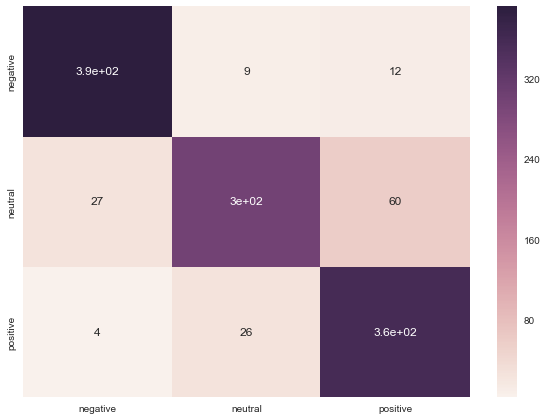

In [42]:
# Test data

vocab_test_tf = vectorizer.transform(test_data)
predicted_labels_LR2 = model_LR.predict(vocab_test_tf)
print "Test dataset with", len(predicted_labels_LR2), "sentences"
print ""

print "Data split - Negative, Neutral, Positive"
print "----------------------------------------"
print "{0:>15} |{1:>15} |{2:>15} |{3:>15}".format("dataset","negative", "neutral", "positive")
print "{0:>15} |{1:>15f} |{2:>15f} |{3:>15f}".format("test_predicted",count_classes(0,predicted_labels_LR2), 
                                                     count_classes(1,predicted_labels_LR2),
                                                     count_classes(2,predicted_labels_LR2))
print "{0:>15} |{1:>15f} |{2:>15f} |{3:>15f}".format("test_actual",count_classes(0,test_labels), 
                                                     count_classes(1,test_labels),
                                                     count_classes(2,test_labels))

accuracy = model_LR.score(vocab_test_tf, test_labels)
print "\nAccuracy"
print "--------"
print "Accuracy (test data): %.3f" %(accuracy)

print "\nClassification Report"
print "---------------------"
print classification_report(test_labels, predicted_labels_LR2)


print "\nConfusion matrix for test data"
print "------------------------------"

array = confusion_matrix(test_labels, predicted_labels_LR2)
df_cm = pd.DataFrame(array, index = ["negative", "neutral", "positive"],
                  columns = ["negative", "neutral", "positive"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)


# Find the most confused pair
cm3 = confusion_matrix(test_labels, predicted_labels_LR2)  # copy the cm matrix so that can modify the copy without affecting original cm
np.fill_diagonal(cm3, 0)  # set the values in the diagonal = 0 to obtain number of confused pairs matrix
maximum_pair_idx = np.where(cm3 == cm3.max())  # returns the indices of the max value in cm matrix
true_interaction = maximum_pair_idx[0][0]
predicted_interaction = maximum_pair_idx[1][0]
max_wrong_prediction = cm3[true_interaction][predicted_interaction]
print "The most confused pair of classes is:", true_interaction, "(", classes_dict[true_interaction],")",\
" incorrectly predicted as", predicted_interaction, "(", classes_dict[predicted_interaction],")"
print "Number of such confusion occurences:", max_wrong_prediction

# Analysis of Errors

## 1. Words with the highest weights per class

In [43]:
vectorizer = TfidfVectorizer()
vocab_train = vectorizer.fit_transform(train_data)
vocab_dev = vectorizer.transform(dev_data)
feature_names = vectorizer.get_feature_names()

model_LR = LogisticRegression(C=50)
model_LR.fit(vocab_train, train_labels)
predicted_labels_LR = model_LR.predict(vocab_dev)

weights = model_LR.coef_   # weight vector for each label
top30_features_index = []  # list of 30 features (10 words with the largest weights for each label)
class_list = ['negative', 'neutral', 'positive']

for i in range(3):  # 4 labels
    weights_label_i = list(weights[i])  # list of weights for label i
    top10_weights_label_i = sorted(weights_label_i, reverse=True)[0:10]  # sort and filter greatest 10 weights
    top10_features_index_i = [weights_label_i.index(weight) \
                             for weight in top10_weights_label_i]  # find index of top 10
    top10_features_i = [feature_names[index] for index in top10_features_index_i]  # list of features of top 10 weights
    top30_features_index += top10_features_index_i  # add the top 10 weigths index of label i to the list of 30

    # Print top 5 features per label
    print "Class", i, "(", class_list[i] , ")"
    for index, (weight, feature) in enumerate(zip(top10_weights_label_i,top10_features_i), start = 1):
        print index, "weight: %.3f" %(weight), "for feature \"", feature, "\""

top30_features = [feature_names[index] for index in top30_features_index]  # list of features of top 20 weights

# Formatting weights for each class for printing table of results
top30_w_class0 = ["%.3f" %(list(weights[0])[index]) for index in top30_features_index]
top30_w_class1 = ["%.3f" %(list(weights[1])[index]) for index in top30_features_index]
top30_w_class2 = ["%.3f" %(list(weights[2])[index]) for index in top30_features_index]



weights_array = np.column_stack((top30_w_class0, top30_w_class1, top30_w_class2))

# Print table of weights for the 20 top features
print "\nTable of weights for each feature for each of the 3 labels:\n"
row_format ="{:>20}" * (len(class_list) + 1)
print row_format.format("", *class_list)
for feature, weights in zip(top30_features, weights_array):
    print row_format.format(feature, *weights)


Class 0 ( negative )
1 weight: 8.383 for feature " induced "
2 weight: 7.360 for feature " hepatotoxicity "
3 weight: 7.242 for feature " inhibited "
4 weight: 6.935 for feature " metabolism "
5 weight: 6.860 for feature " acetylneuraminic "
6 weight: 6.381 for feature " inhibit "
7 weight: 6.363 for feature " nicotine "
8 weight: 6.144 for feature " stimulated "
9 weight: 6.017 for feature " reduce "
10 weight: 5.950 for feature " capsaicin "
Class 1 ( neutral )
1 weight: 9.064 for feature " study "
2 weight: 7.298 for feature " on "
3 weight: 7.073 for feature " investigated "
4 weight: 6.316 for feature " no "
5 weight: 5.741 for feature " were "
6 weight: 5.448 for feature " we "
7 weight: 5.370 for feature " nitrite "
8 weight: 5.177 for feature " oxygen "
9 weight: 5.042 for feature " mouse "
10 weight: 4.850 for feature " examined "
Class 2 ( positive )
1 weight: 8.692 for feature " inhibitory "
2 weight: 7.158 for feature " lovastatin "
3 weight: 6.737 for feature " diabetic "


** Observations **  
**BEFORE** bootstrapping:
1. Some neutral prediction words seem promising, in particular, "study", "investigated", "studied"
2. Some negative and positive prediciton words seem helpful
3. Main weakness of the model: this is a bag of word model with feature based on tf-idf. Thus, a drug name or food compound can also result with an important weight to predict a class and this is misleading. For example, "monoamine" has a high weight for class "positive" based on the positive labels of sentences containing this word. Thus, even if we will add a sentence with a negative interaction between monoamine and a food compound, the BOW model will predict a positive label. The proportion of labels for a drug-food interaction sentences in the training will affect how the model will retain those drugs or food compounds as predictors of positive/negative/neutral. 

**AFTER** bootstrapping:
similar to above but seems to have less drug and food related words with high weight for predicting label

## 2. R-ratio analysis - look at individual sentences with highest errors

R is equal to maximum predicted probability divided by predicted probability of the correct label.  
In other words, it looks how "far" the prediction of a class is from the true class.


In [44]:
vectorizer = TfidfVectorizer()
vocab_train_tf = vectorizer.fit_transform(train_data)
vocab_dev_tf = vectorizer.transform(dev_data)
feature_names = vectorizer.get_feature_names()

# Logistic regression model with C=50
model_LR = LogisticRegression(C=50)
model_LR.fit(vocab_train_tf, train_labels)
predicted_labels_LR = model_LR.predict(vocab_dev_tf)

#feature_names = vectorizer.get_feature_names()
#print "features names length:", len(feature_names)

    
# Variables to calculate R
probabilities = model_LR.predict_proba(vocab_dev_tf)  # Each label probability (4) for each document
proba_max = probabilities.max(axis=1)  # Maximum predicted probability
proba_correct_label = [probabilities[i][dev_labels[i]] \
                       for i in range(probabilities.shape[0])]  # Predicted prob of the correct label
r_ratio = proba_max/proba_correct_label  # R = maximum predicted prob / predicted prob of the correct label
sentence_index = [i for i in range(probabilities.shape[0])]  # Index of the document to retrace once sorted by R

# Results array with 5 columns (R, max prob, prob of correct label, predicted labels, true labels,
# document index)
results = np.column_stack((r_ratio, proba_max, proba_correct_label, predicted_labels_LR, \
                           dev_labels, sentence_index))
results_max3r = sorted(results, key=lambda x: x[0], reverse=True)[:10]  # top 10 sentences with highest R


# Format and print top 3 documents with highest R:
# 1) print top 10 sentences related info - probabilities, predicted/correct labels, etc.
print "\nTop 10 sentences where the ratio R is largest:\n"
column_names = ["ratio R", "Max pred Pr", "Correct Pr", "Predicted label", "True label", \
                "Doc Index"]
row_format ="{:>16}" * (len(column_names)+1)
print row_format.format("", *column_names)
top_10 = ["Highest R", "2nd highest", "3rd highest", "4th", "5th", "6th", "7th", "8th", "9th", "10th"]
for index, row in zip(top_10, results_max3r):
    row = [round(item,3) for item in row]
    print row_format.format(index, *row)

# 2) print top 3 R documents messages
print "\nSentences:"
i = 1
for row in results_max3r:
    print "\n" + str(i) +") Sentence with ratio R = %.3f" %(row[0]), ":"
    print dev_data[int(row[5])]
    i +=1  


# Diagnosis of influential words in the 3 documents with highest R
weights = model_LR.coef_
sentence_list = [int(result[5]) for result in results_max3r]
j=1

for example in sentence_list:
    predicted_label = predicted_labels_LR[example]
    indices = vocab_dev_tf[example].indices  # list of indices of non zero features of document
    vocab_freq = vocab_dev_tf[example].data  # list of features values of document
    weights_example = [weights[predicted_label][index] for index in indices]  # list of LR weights 
                                                                              # for non zero features of doc
    feature_importance = vocab_freq * weights_example  # feature value x weight for total influence on prediction

    features_array = np.column_stack((feature_importance, indices))
    features_sorted = sorted(features_array, key=lambda x: x[0], reverse=True)  # Sort words by influence

    # Print top 5 features (words) of the document with heaviest weight x value
    
    print "\nSentence", j,  "(example number", example, "):"
    for i in range(5):
        index = int(features_sorted[i][1])
        print "Influential word:", feature_names[index] ,"with magnitude:", features_sorted[i][0]
    j +=1



Top 10 sentences where the ratio R is largest:

                         ratio R     Max pred Pr      Correct Pr Predicted label      True label       Doc Index
       Highest R          470.47           0.973           0.002             1.0             0.0           553.0
     2nd highest          470.47           0.973           0.002             1.0             0.0          1026.0
     3rd highest         382.687           0.786           0.002             2.0             1.0           645.0
             4th         307.791           0.694           0.002             0.0             1.0           451.0
             5th         166.621           0.558           0.003             2.0             1.0           450.0
             6th         161.567           0.984           0.006             1.0             2.0           511.0
             7th         161.567           0.984           0.006             1.0             2.0           958.0
             8th         145.674           0.98

# Model Improvement

In [48]:
## 1. Preprocessor

In [49]:
def empty_preprocessor(s):
    return s

def better_preprocessor(s):
    #s = s.lower()  # to lowercase all letters in the string
    #s = re.sub("[^a-zA-Z0-9]", " ", s) # to remove non-letter and non-numerical characters
    #s = re.sub ('\d+', " numsequence ",s)  # replace sequences of numbers with a single token
    
    pronoun_list = ['you', 'he', 'she', 'we', 'they', 'me', 'him', 'his', 'her', 'hers', 'yours', 'us', 'our'\
                   'ours', 'their', 'theirs']  # list of pronouns as stopwords since not informative for prediciton
    for word in pronoun_list:
        s = re.sub(r'\b%s\b' % word, " ",s)  # to remove stopwords in the list
        
    nothelping = ['or', 'to', 'of', 'a', 'on', 'the']
    for word in nothelping:
        s = re.sub(r'\b%s\b' % word, " ",s)  # to remove stopwords in the list
        
    #s = re.sub(r'ly\b', "",s)   # to remove "ly" from words ending by "ly"
    s = re.sub(r'ing\b', "",s)  # to remove "ing" from words ending by "ing"
    #s = re.sub(r's\b', "",s)    # to remove "s" from words ending by "s"
    
    for word in s.split():  # to shorten words longer than 15 characters (from histogram, most words < 15)
        if len(word)>15:
            short_word = word[:15]
            s = s.replace(word,short_word)
    
    return s

In [50]:
# No preprocessor
vectorizer_initial = TfidfVectorizer()
vocab_train_initial = vectorizer_initial.fit_transform(train_data)
vocab_test_initial = vectorizer_initial.transform(test_data)
count_features_init = len(vectorizer_initial.get_feature_names())
print "Size of vocabulary with no preprocessor:", count_features_init

model_LR_initial = LogisticRegression(C=50)
model_LR_initial.fit(vocab_train_initial, train_labels)
predicted_labels_initial = model_LR_initial.predict(vocab_test_initial)
accuracy_initial = model_LR_initial.score(vocab_test_initial, test_labels)
print "accuracy with no custom preprocessor is: %.3f" %(accuracy_initial)
print ""


# With preprocessor
vectorizer_better = TfidfVectorizer(preprocessor=better_preprocessor)
vocab_train_better = vectorizer_better.fit_transform(train_data)
vocab_test_better = vectorizer_better.transform(test_data)

count_features_better = len(vectorizer_better.get_feature_names())
print "Size of vocabulary with custom preprocessor:", count_features_better

model_LR_better = LogisticRegression(C=50)
model_LR_better.fit(vocab_train_better, train_labels)
predicted_labels_better = model_LR_better.predict(vocab_test_better)
accuracy_better = model_LR_better.score(vocab_test_better, test_labels)
print "accuracy with custom preprocessor is: %.3f" %(accuracy_better)

Size of vocabulary with no preprocessor: 8141
accuracy with no custom preprocessor is: 0.884

Size of vocabulary with custom preprocessor: 8727
accuracy with custom preprocessor is: 0.880


## 2. N-grams instead of unigrams

In [51]:
# Turn the raw training text into feature vectors based on "td-idf"
vectorizer = TfidfVectorizer(analyzer='word' , ngram_range=(4,5), preprocessor=better_preprocessor)
vocab_train_tf = vectorizer.fit_transform(train_data)
vocab_dev_tf = vectorizer.transform(dev_data)

# Logistic regression model with C=50
model_LR = LogisticRegression(C=50)
model_LR.fit(vocab_train_tf, train_labels)
predicted_labels_LR_ngram = model_LR.predict(vocab_dev_tf)

accuracy = model_LR.score(vocab_dev_tf, dev_labels)
print "Accuracy (dev data): %.3f" %(accuracy)

vocab_test_tf = vectorizer.transform(test_data)
predicted_labels_LR_ngram2 = model_LR.predict(vocab_test_tf)
accuracy = model_LR.score(vocab_test_tf, test_labels)
print "Accuracy (test data): %.3f" %(accuracy)

Accuracy (dev data): 0.886
Accuracy (test data): 0.886


# SVM model

In [45]:
vectorizer = TfidfVectorizer()
vocab_train_tf = vectorizer.fit_transform(train_data)
vocab_dev_tf = vectorizer.transform(dev_data)
vocab_test_tf = vectorizer.transform(test_data)

In [46]:
import time
# Support Vector Machines:
print "Evaluating Support Vector Machine model ..."

# Create a Support Vector Machine model. 
SVMmodel = SVC(C=1.0)

# Create a grid search.
print "Performing grid search for Support Vector Machine model. It may take a few minutes ..."
Cs = {'C': [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0]}
CV_SVMmodel = GridSearchCV(estimator=SVMmodel, param_grid=Cs)

# Fit the models using grid search and display the results.
start_time = time.time()
CV_SVMmodel.fit(vocab_train_tf, train_labels)
end_time = time.time()
print "Support Vector Machines grid search model fitting time = %f seconds." % (end_time - start_time)

optimal_Cs = CV_SVMmodel.best_params_['C']
print "As per the grid search on the training data, the optimal value of C = %f." % optimal_Cs

# Predict labels for dev data and calculate accuracy using optimal C
start_time = time.time()
SVMmodel = CV_SVMmodel.predict(vocab_dev_tf)
end_time = time.time()
print "Support Vector Machines prediction time for dev data = %f seconds." % (end_time - start_time)

# Print goodness of fit measures
print "Accuracy on dev data for Support Vector Machine is = %f" % CV_SVMmodel.score(vocab_dev_tf, dev_labels)
print "Classification Report\n", classification_report(dev_labels, SVMmodel)  

Evaluating Support Vector Machine model ...
Performing grid search for Support Vector Machine model. It may take a few minutes ...
Support Vector Machines grid search model fitting time = 41.158077 seconds.
As per the grid search on the training data, the optimal value of C = 0.000100.
Support Vector Machines prediction time for dev data = 0.632714 seconds.
Accuracy on dev data for Support Vector Machine is = 0.336417
Classification Report
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       387
          1       0.34      1.00      0.50       400
          2       0.00      0.00      0.00       402

avg / total       0.11      0.34      0.17      1189



/Applications/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


SVM model
Accuracy (dev data): 0.336
Test dataset with 1189 sentences
Accuracy (test data): 0.326
        dataset |       negative |        neutral |       positive
 test_predicted |       0.000000 |    1189.000000 |       0.000000
    test_actual |     414.000000 |     388.000000 |     387.000000
Confusion matrix for test data
The most confused pair of classes is: 0 ( negative )  incorrectly predicted as 1 ( neutral )
Number of such confusion occurences: 414


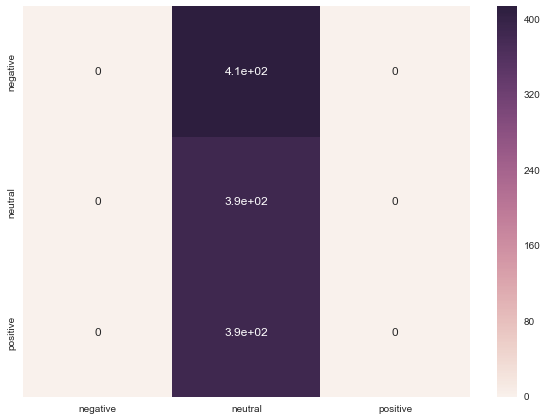

In [47]:
# Turn the raw training text into feature vectors based on "td-idf"
#vectorizer = TfidfVectorizer()
#vocab_train_tf = vectorizer.fit_transform(train_data)
#vocab_dev_tf = vectorizer.transform(dev_data)

# SVM model
model_SVM = SVC(C=0.0001)
model_SVM.fit(vocab_train_tf, train_labels)
predicted_labels_SVM = model_SVM.predict(vocab_dev_tf)

# DEV
print "SVM model"
accuracy = model_SVM.score(vocab_dev_tf, dev_labels)
print "Accuracy (dev data): %.3f" %(accuracy)

# TEST
vocab_test_tf = vectorizer.transform(test_data)
predicted_labels_SVM2 = model_SVM.predict(vocab_test_tf)
print "Test dataset with", len(predicted_labels_SVM2), "sentences"
accuracy = model_SVM.score(vocab_test_tf, test_labels)
print "Accuracy (test data): %.3f" %(accuracy)

print "{0:>15} |{1:>15} |{2:>15} |{3:>15}".format("dataset","negative", "neutral", "positive")
print "{0:>15} |{1:>15f} |{2:>15f} |{3:>15f}".format("test_predicted",count_classes(0,predicted_labels_SVM2), 
                                                     count_classes(1,predicted_labels_SVM2),
                                                     count_classes(2,predicted_labels_SVM2))
print "{0:>15} |{1:>15f} |{2:>15f} |{3:>15f}".format("test_actual",count_classes(0,test_labels), 
                                                     count_classes(1,test_labels),
                                                     count_classes(2,test_labels))

print "Confusion matrix for test data"

array = confusion_matrix(test_labels, predicted_labels_SVM2)
df_cm = pd.DataFrame(array, index = ["negative", "neutral", "positive"],
                  columns = ["negative", "neutral", "positive"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)


# Find the most confused pair
cm3 = confusion_matrix(test_labels, predicted_labels_SVM2)  # copy the cm matrix so that can modify the copy without affecting original cm
np.fill_diagonal(cm3, 0)  # set the values in the diagonal = 0 to obtain number of confused pairs matrix
maximum_pair_idx = np.where(cm3 == cm3.max())  # returns the indices of the max value in cm matrix
true_interaction = maximum_pair_idx[0][0]
predicted_interaction = maximum_pair_idx[1][0]
max_wrong_prediction = cm3[true_interaction][predicted_interaction]
print "The most confused pair of classes is:", true_interaction, "(", classes_dict[true_interaction],")",\
" incorrectly predicted as", predicted_interaction, "(", classes_dict[predicted_interaction],")"
print "Number of such confusion occurences:", max_wrong_prediction